## **Computer vision project: Deggendorf Waste Sorting Assistant**

### **Overview**
The Deggendorf Waste Sorting Assistant is a Computer Vision-based tool designed to help residents and international students correctly identify waste bins. The project leverages image classification to determine the category of a given waste bin based on its visual characteristics. Users can take a picture of an unlabeled bin, and the model will classify it while providing information on the appropriate waste materials for disposal.

### **Project Goals**
- Develop an image classification model capable of identifying waste bins in Deggendorf.
- Provide users with clear guidance on proper waste disposal based on bin classification.
- Document all processes in a Jupyter Notebook, covering dataset creation, model training, evaluation, and deployment.


---

## **1. Environment Setup & Dependencies**

```bash
# Using conda
conda create -n waste-detection python=3.10
conda activate waste-detection
```

In [1]:
# 1.0 · Check environment and install dependencies (FIXED with QuickFix)
import os
import sys
import subprocess
import importlib
from pathlib import Path

def is_colab():
    """Check if running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

def reinstall_package(package):
    """Reinstall a package (force reinstall)"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--force-reinstall", package])

# QUICKFIX: Check for NumPy binary compatibility issues
print("🔧 Running NumPy compatibility check...")
numpy_needs_fix = False
try:
    import numpy
    # Test numpy functionality - this is where the error typically occurs
    test_array = numpy.array([1, 2, 3])
    numpy.random.RandomState(42)  # This often triggers the binary incompatibility error
    print(f"✅ NumPy {numpy.__version__} working correctly")
except (ImportError, ValueError) as e:
    print(f"❌ NumPy binary compatibility issue detected: {e}")
    numpy_needs_fix = True

if numpy_needs_fix:
    print("🔧 Applying NumPy QuickFix...")
    # Force reinstall numpy and related packages
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--force-reinstall", "--no-deps", "--quiet", "numpy>=1.23.0"])
    print("✅ NumPy reinstalled - you may need to restart runtime")

    # Test again after reinstall
    try:
        import numpy
        test_array = numpy.array([1, 2, 3])
        print("✅ NumPy QuickFix successful")
    except Exception as e:
        print(f"⚠️ NumPy still has issues: {e}")
        print("💡 Please restart the runtime and run this cell again")

print("\n📦 Installing dependencies...")

# Core dependencies in installation order
core_packages = [
    "pillow>=10.0.0",
    "opencv-python>=4.6.0",
    "matplotlib>=3.5.0",
    "pandas>=2.0.0",
    "seaborn>=0.12.0",
    "pyyaml>=6.0",
    "tqdm>=4.64.0",
    "shutil"
]

# Install core packages
for pkg in core_packages:
    try:
        module_name = pkg.split('>=')[0].replace('-', '_')
        if module_name == 'opencv_python':
            module_name = 'cv2'
        importlib.import_module(module_name)
        print(f"✅ {pkg.split('>=')[0]} already installed")
    except ImportError:
        print(f"Installing {pkg}...")
        install_package(pkg)

# Install Ultralytics
try:
    import ultralytics
    print("✅ ultralytics already installed")
except ImportError:
    print("Installing ultralytics>=8.0.0...")
    install_package("ultralytics>=8.0.0")

# Install Label Studio (optional - may fail, that's okay)
label_studio_packages = [
    "label-studio>=1.0.0",
    "label-studio-converter>=0.0.1",
]

print("\nInstalling Label Studio packages (optional)...")
for pkg in label_studio_packages:
    try:
        module_name = pkg.split('>=')[0].replace('-', '_')
        importlib.import_module(module_name)
        print(f"✅ {pkg.split('>=')[0]} already installed")
    except ImportError:
        try:
            print(f"Installing {pkg}...")
            install_package(pkg)
        except subprocess.CalledProcessError:
            print(f"⚠️ Could not install {pkg} - continuing without it")

print("\n🔍 Final verification...")

# Verify critical imports
critical_imports = {
    'numpy': 'numpy',
    'cv2': 'opencv-python',
    'PIL': 'pillow',
    'matplotlib': 'matplotlib',
    'pandas': 'pandas',
    'yaml': 'pyyaml',
    'ultralytics': 'ultralytics',
    'shutil': 'shutil'
}

all_good = True
for module, package in critical_imports.items():
    try:
        importlib.import_module(module)
        print(f"✅ {module}")
    except ImportError as e:
        print(f"❌ {module} failed: {e}")
        all_good = False

if all_good:
    print("\n🎉 All dependencies installed and verified successfully!")
else:
    print("\n⚠️ Some packages failed - you may need to restart runtime and try again")

print("\n💡 If you see 'numpy.dtype size changed' errors, restart the runtime and run this cell again.")

🔧 Running NumPy compatibility check...
✅ NumPy 2.0.2 working correctly

📦 Installing dependencies...
Installing pillow>=10.0.0...
✅ opencv-python already installed
✅ matplotlib already installed
✅ pandas already installed
✅ seaborn already installed
Installing pyyaml>=6.0...
✅ tqdm already installed
✅ shutil already installed
Installing ultralytics>=8.0.0...

Installing Label Studio packages (optional)...
Installing label-studio>=1.0.0...
Installing label-studio-converter>=0.0.1...

🔍 Final verification...
✅ numpy
✅ cv2
✅ PIL
✅ matplotlib
✅ pandas
✅ yaml
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ ultralytics
✅ shutil

🎉 All dependencies installed and verified successfully!

💡 If you see 'numpy.dtype size changed' errors,

In [2]:
# 1.1 · Mount Google Drive (if in Colab)
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    BASE_PATH = Path("/content/drive/MyDrive/cv_garbage")
else:
    # For local environment, adjust this path
    BASE_PATH = Path("./cv_garbage")

# Create directory structure
DIRS = {
    "raw_images": BASE_PATH / "raw_images",
    "labeled_images": BASE_PATH / "labeled_images",
    "yolo_dataset": BASE_PATH / "YOLO_Dataset",
    "models": BASE_PATH / "models",
    "results": BASE_PATH / "results"
}

for dir_name, dir_path in DIRS.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"📁 {dir_name}: {dir_path}")

Mounted at /content/drive
📁 raw_images: /content/drive/MyDrive/cv_garbage/raw_images
📁 labeled_images: /content/drive/MyDrive/cv_garbage/labeled_images
📁 yolo_dataset: /content/drive/MyDrive/cv_garbage/YOLO_Dataset
📁 models: /content/drive/MyDrive/cv_garbage/models
📁 results: /content/drive/MyDrive/cv_garbage/results


---

## **2. Data Annotation Pipeline**

### **2.1 Check Existing Annotations**


In [3]:
# 2.1 · Check if YOLO annotations already exist
import json
import yaml
from datetime import datetime

def check_yolo_dataset():
    """Check if YOLO dataset structure exists and is valid"""
    yolo_path = DIRS["yolo_dataset"]
    required_structure = {
        "images/train": 0,
        "images/val": 0,
        "labels/train": 0,
        "labels/val": 0,
        "data.yaml": None
    }

    dataset_valid = True

    for rel_path in required_structure.keys():
        full_path = yolo_path / rel_path
        if "data.yaml" in rel_path:
            if not full_path.exists():
                print(f"❌ Missing: {rel_path}")
                dataset_valid = False
            else:
                with open(full_path, 'r') as f:
                    data_config = yaml.safe_load(f)
                print(f"✅ Found data.yaml with {data_config.get('nc', 0)} classes")
        else:
            if full_path.exists():
                if full_path.is_dir():
                    count = len(list(full_path.glob("*")))
                    required_structure[rel_path] = count
                    print(f"✅ {rel_path}: {count} files")
                    if count == 0:
                        dataset_valid = False
            else:
                print(f"❌ Missing: {rel_path}")
                dataset_valid = False

    return dataset_valid, required_structure

dataset_exists, dataset_info = check_yolo_dataset()
print(f"\n{'✅ YOLO dataset is ready!' if dataset_exists else '⚠️  YOLO dataset needs to be created'}")

✅ images/train: 360 files
✅ images/val: 93 files
✅ labels/train: 372 files
✅ labels/val: 94 files
✅ Found data.yaml with 4 classes

✅ YOLO dataset is ready!


### **2.2 Label Studio Setup (If Needed)**

In [4]:
# 2.2 · Setup Label Studio for bounding box annotation
if not dataset_exists:
    print("\n🏷️  Setting up Label Studio for annotation...")

    # Create Label Studio config
    label_config = """
    <View>
      <Image name="image" value="$image"/>
      <RectangleLabels name="label" toName="image">
        <Label value="Biomüll" background="#FF6B6B"/>
        <Label value="Glas" background="#4ECDC4"/>
        <Label value="Papier" background="#45B7D1"/>
        <Label value="Restmüll" background="#96CEB4"/>
      </RectangleLabels>
    </View>
    """

    config_path = BASE_PATH / "label_studio_config.xml"
    with open(config_path, 'w') as f:
        f.write(label_config)

    print("✅ Label Studio configuration created")
    print("\n📋 Instructions for Label Studio:")
    print("1. Run: label-studio start")
    print("2. Create a new project")
    print("3. Import the configuration from:", config_path)
    print("4. Import images from:", DIRS["labeled_images"])
    print("5. Annotate with bounding boxes")
    print("6. Export annotations as 'YOLO' format")
    print("7. Save to:", DIRS["yolo_dataset"])

    # For automated setup (requires Label Studio SDK)
    try:
        from label_studio_sdk import Client

        # Initialize Label Studio client
        LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL', 'http://localhost:8080')
        API_KEY = os.getenv('LABEL_STUDIO_API_KEY', '')

        if API_KEY:
            ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

            # Create project
            project = ls.start_project(
                title="Deggendorf Waste Bins",
                label_config=label_config
            )

            # Import images
            image_files = list(DIRS["labeled_images"].glob("*.jpg")) + \
                         list(DIRS["labeled_images"].glob("*.png"))

            if image_files:
                project.import_data([{"image": str(f)} for f in image_files])
                print(f"✅ Imported {len(image_files)} images to Label Studio")
                print(f"🌐 Open Label Studio at: {LABEL_STUDIO_URL}")
            else:
                print("⚠️  No images found in labeled_images directory")
        else:
            print("\n💡 Tip: Set LABEL_STUDIO_API_KEY environment variable for automated setup")
    except ImportError:
        print("\n💡 Install label-studio-sdk for automated project setup")

### **2.3 Convert Label Studio to YOLO Format**

In [5]:
# 2.3 · Convert Label Studio annotations to YOLO format
def convert_ls_to_yolo(ls_export_path, output_path):
    """Convert Label Studio JSON export to YOLO format"""
    import json
    import shutil
    from PIL import Image

    # Load Label Studio export
    with open(ls_export_path, 'r') as f:
        ls_data = json.load(f)

    # Class mapping
    class_map = {
        "Biomüll": 0,
        "Glas": 1,
        "Papier": 2,
        "Restmüll": 3
    }

    # Prepare directories
    for split in ['train', 'val']:
        (output_path / 'images' / split).mkdir(parents=True, exist_ok=True)
        (output_path / 'labels' / split).mkdir(parents=True, exist_ok=True)

    # Process annotations
    total_images = len(ls_data)
    train_split = int(0.8 * total_images)

    for idx, item in enumerate(ls_data):
        # Determine split
        split = 'train' if idx < train_split else 'val'

        # Get image info
        image_path = Path(item['data']['image'])
        image_name = image_path.stem

        # Copy image
        output_image_path = output_path / 'images' / split / f"{image_name}.jpg"
        if image_path.exists():
            shutil.copy2(image_path, output_image_path)

            # Get image dimensions
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        else:
            print(f"⚠️  Image not found: {image_path}")
            continue

        # Process annotations
        yolo_annotations = []

        for annotation in item.get('annotations', []):
            for result in annotation.get('result', []):
                if result['type'] == 'rectanglelabels':
                    # Get bounding box
                    x = result['value']['x'] / 100.0
                    y = result['value']['y'] / 100.0
                    w = result['value']['width'] / 100.0
                    h = result['value']['height'] / 100.0

                    # Convert to YOLO format (center_x, center_y, width, height)
                    center_x = x + w / 2
                    center_y = y + h / 2

                    # Get class
                    label = result['value']['rectanglelabels'][0]
                    class_id = class_map.get(label, -1)

                    if class_id >= 0:
                        yolo_annotations.append(f"{class_id} {center_x} {center_y} {w} {h}")

        # Save annotations
        if yolo_annotations:
            label_path = output_path / 'labels' / split / f"{image_name}.txt"
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))

    # Create data.yaml
    data_yaml = {
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_map),
        'names': {v: k for k, v in class_map.items()}
    }

    with open(output_path / 'data.yaml', 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print(f"✅ Converted {total_images} images to YOLO format")
    print(f"   Train: {train_split}, Val: {total_images - train_split}")

# Check if Label Studio export exists
ls_export_path = BASE_PATH / "label_studio_export.json"
if ls_export_path.exists() and not dataset_exists:
    print("\n🔄 Converting Label Studio annotations to YOLO format...")
    convert_ls_to_yolo(ls_export_path, DIRS["yolo_dataset"])
    dataset_exists, dataset_info = check_yolo_dataset()

---

## **3. Model Training**

### **3.1 Setup Training Configuration**


In [6]:
# 3.1 · Configure training parameters
import torch
from ultralytics import YOLO

# Training configuration
TRAIN_CONFIG = {
    "model": "yolov8s.pt",  # Base model (n, s, m, l, x)
    "data": str(DIRS["yolo_dataset"] / "data.yaml"),
    "epochs": 50,
    "imgsz": 960,
    "batch": 16 if torch.cuda.is_available() else 8,
    "patience": 20,
    "save": True,
    "device": 0 if torch.cuda.is_available() else "cpu",
    "workers": 8 if not is_colab() else 2,
    "project": str(DIRS["models"]),
    "name": f"waste_detector_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    "exist_ok": False,
    "pretrained": True,
    "optimizer": "AdamW",
    "lr0": 0.001,
    "lrf": 0.01,
    "momentum": 0.937,
    "weight_decay": 0.0005,
    "warmup_epochs": 3.0,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1,
    "box": 7.5,
    "cls": 0.5,
    "dfl": 1.5,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "perspective": 0.0,
    "flipud": 0.0,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "mixup": 0.0,
    "copy_paste": 0.0,
    "auto_augment": "randaugment",
    "erasing": 0.0,
    "crop_fraction": 1.0
}

print("🔧 Training Configuration:")
print(f"   Device: {TRAIN_CONFIG['device']}")
print(f"   Batch size: {TRAIN_CONFIG['batch']}")
print(f"   Epochs: {TRAIN_CONFIG['epochs']}")
print(f"   Model: {TRAIN_CONFIG['model']}")

🔧 Training Configuration:
   Device: 0
   Batch size: 16
   Epochs: 50
   Model: yolov8s.pt


### **3.2 Train the Model**


In [14]:
# 3.2 · Train YOLO model
import shutil

if dataset_exists:
    print("\n🚀 Starting model training...")

    # # Initialize model
    # model = YOLO(TRAIN_CONFIG["model"])

    # # Train model
    # results = model.train(**TRAIN_CONFIG)

    # # Fix: Construct the save directory path manually from training config
    # # This is more robust than accessing internal trainer attributes
    # save_dir = Path(TRAIN_CONFIG["project"]) / TRAIN_CONFIG["name"]
    save_dir = Path("/content/drive/MyDrive/cv_garbage/models") / "waste_detector_20250625_1422522"
    best_model_path = save_dir / "weights" / "best.pt"

    # Alternative fix: Access save_dir from the model's trainer
    # best_model_path = Path(model.trainer.save_dir) / "weights" / "best.pt"

    print(f"\n✅ Training completed!")
    print(f"   Best model saved at: {best_model_path}")

    # Verify the file exists before copying
    if best_model_path.exists():
        # Copy best model to a fixed location
        final_model_path = DIRS["models"] / "waste_detector_best.pt"
        shutil.copy2(best_model_path, final_model_path)
        print(f"   Copied to: {final_model_path}")
    else:
        print(f"   ⚠️ Warning: Best model file not found at {best_model_path}")
        # Try alternative path
        last_model_path = save_dir / "weights" / "last.pt"
        if last_model_path.exists():
            final_model_path = DIRS["models"] / "waste_detector_last.pt"
            shutil.copy2(last_model_path, final_model_path)
            print(f"   Using last model instead: {final_model_path}")

    # Optional: Print training metrics
    if hasattr(results, 'box'):
        print(f"\n📊 Training Results:")
        print(f"   mAP50: {results.box.map50:.3f}")
        print(f"   mAP50-95: {results.box.map:.3f}")
        print(f"   Precision: {results.box.mp:.3f}")
        print(f"   Recall: {results.box.mr:.3f}")
else:
    print("\n⚠️  Cannot train model - YOLO dataset not found!")
    print("Please complete the annotation step first.")


🚀 Starting model training...

✅ Training completed!
   Best model saved at: /content/drive/MyDrive/cv_garbage/models/waste_detector_20250625_1422522/weights/best.pt
   Copied to: /content/drive/MyDrive/cv_garbage/models/waste_detector_best.pt

📊 Training Results:
   mAP50: 0.987
   mAP50-95: 0.781
   Precision: 0.979
   Recall: 0.948


## **4. Model Evaluation**


### **4.1 Evaluate Model Performance**


In [15]:
# 4.1 · Evaluate the trained model
if dataset_exists and 'final_model_path' in locals():
    print("\n📊 Evaluating model performance...")

    # Load best model
    model = YOLO(final_model_path)

    # Run validation
    metrics = model.val(
        data=TRAIN_CONFIG["data"],
        imgsz=TRAIN_CONFIG["imgsz"],
        batch=TRAIN_CONFIG["batch"],
        conf=0.25,
        iou=0.6,
        device=TRAIN_CONFIG["device"]
    )

    # Print metrics
    print("\n📈 Model Performance Metrics:")
    print(f"   mAP50: {metrics.box.map50:.3f}")
    print(f"   mAP50-95: {metrics.box.map:.3f}")
    print(f"   Precision: {metrics.box.mp:.3f}")
    print(f"   Recall: {metrics.box.mr:.3f}")

    # Class-wise performance
    print("\n📊 Per-Class Performance:")
    class_names = model.names
    for i, class_name in class_names.items():
        print(f"   {class_name}:")
        print(f"      AP50: {metrics.box.ap50[i]:.3f}")
        print(f"      AP: {metrics.box.ap[i]:.3f}")


📊 Evaluating model performance...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 573.0±52.8 MB/s, size: 2545.2 KB)


val: Scanning /content/drive/MyDrive/cv_garbage/YOLO_Dataset/labels/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


                   all         93        104       0.97      0.967      0.985      0.801
               Biomüll         21         24      0.975          1      0.995      0.774
                  Glas         12         12          1          1      0.995      0.844
                Papier         26         27      0.961      0.919      0.977      0.775
              Restmüll         39         41      0.946      0.951      0.972      0.811
Speed: 19.5ms preprocess, 19.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val

📈 Model Performance Metrics:
   mAP50: 0.985
   mAP50-95: 0.801
   Precision: 0.970
   Recall: 0.967

📊 Per-Class Performance:
   Biomüll:
      AP50: 0.995
      AP: 0.774
   Glas:
      AP50: 0.995
      AP: 0.844
   Papier:
      AP50: 0.977
      AP: 0.775
   Restmüll:
      AP50: 0.972
      AP: 0.811


### **4.2 Visualize Results**



image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/75642dae-Restm_C3_BCll_88448572.jpg: 960x960 1 Restmüll, 30.1ms
Speed: 11.2ms preprocess, 30.1ms inference, 2.2ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/c6c7e408-Restm_C3_BCll_7e78855a.jpg: 960x960 1 Restmüll, 30.1ms
Speed: 10.8ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/5e8b8596-Biom_C3_BCll_82a70460.jpg: 960x960 2 Biomülls, 59.4ms
Speed: 30.5ms preprocess, 59.4ms inference, 6.9ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/cdf60486-Papier_960be228.jpg: 960x960 1 Papier, 30.6ms
Speed: 20.9ms preprocess, 30.6ms inference, 5.2ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/3a8f3a09-Biom_C3_

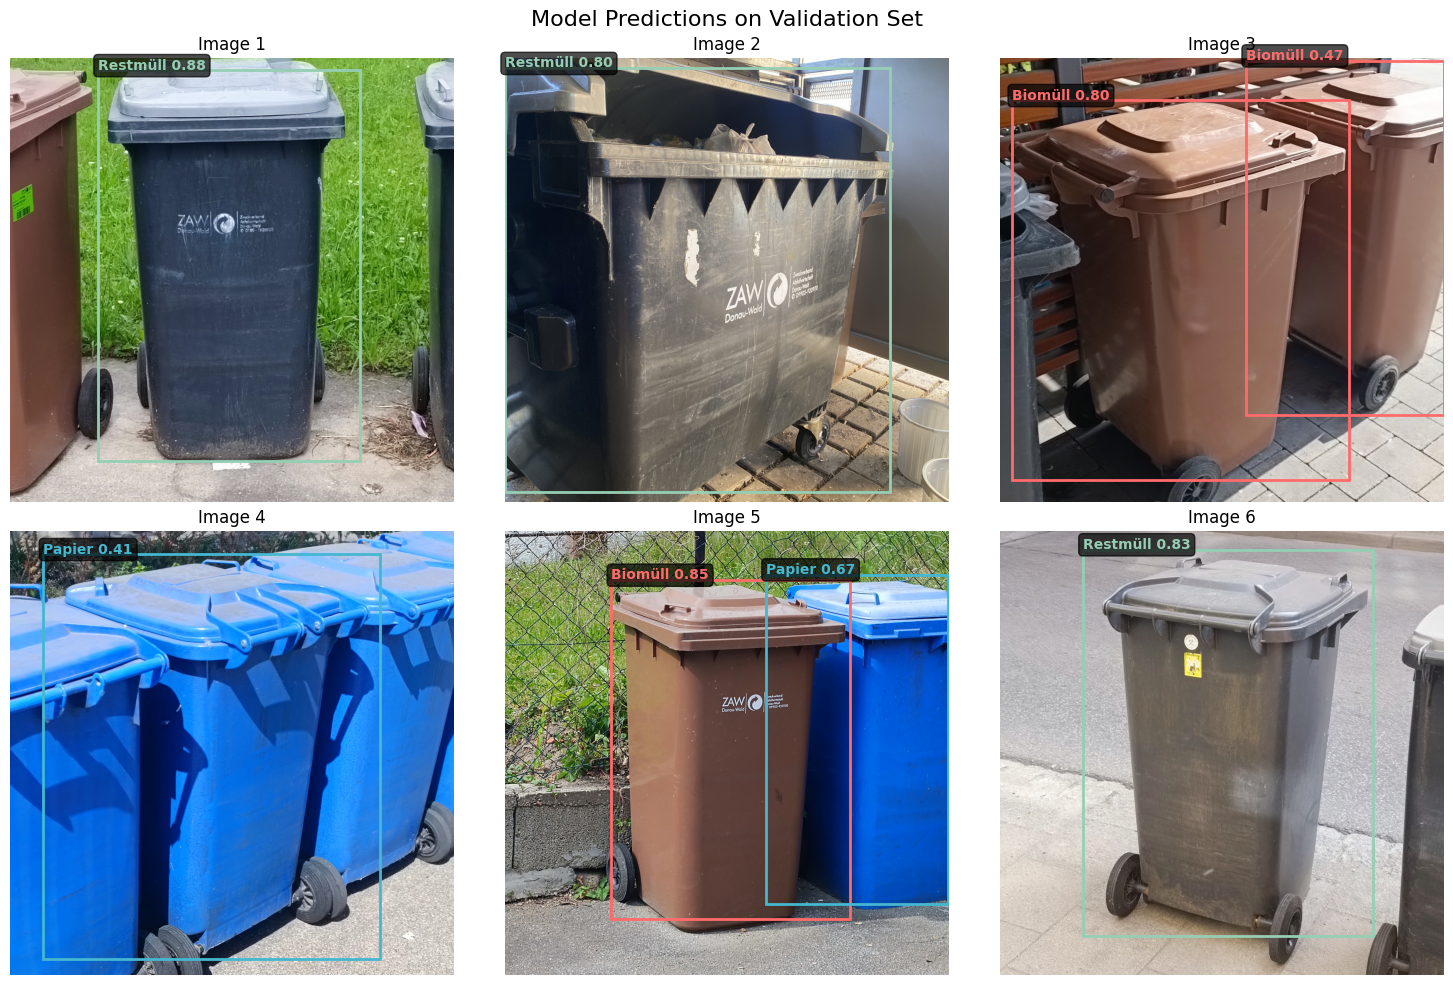

✅ Visualization saved to: /content/drive/MyDrive/cv_garbage/results/validation_predictions.png


In [16]:
# 4.2 · Visualize predictions on validation set
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.patches import Rectangle

def visualize_predictions(model_path, data_yaml_path, num_samples=6):
    """Visualize model predictions on validation images"""

    # Load model and data config
    model = YOLO(model_path)
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Get validation images
    val_images_dir = Path(data_yaml_path).parent / data_config['val']
    val_images = list(val_images_dir.glob("*.jpg")) + list(val_images_dir.glob("*.png"))

    if not val_images:
        print("No validation images found!")
        return

    # Sample random images
    sample_images = np.random.choice(val_images, min(num_samples, len(val_images)), replace=False)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    colors = {
        0: '#FF6B6B',  # Biomüll - Red
        1: '#4ECDC4',  # Glas - Turquoise
        2: '#45B7D1',  # Papier - Blue
        3: '#96CEB4'   # Restmüll - Green
    }

    for idx, (ax, img_path) in enumerate(zip(axes, sample_images)):
        # Read image
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Run prediction
        results = model.predict(img_path, conf=0.25, iou=0.45)

        # Display image
        ax.imshow(img_rgb)
        ax.axis('off')

        # Draw predictions
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])

                    # Draw rectangle
                    rect = Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor=colors.get(cls, 'white'),
                                   facecolor='none')
                    ax.add_patch(rect)

                    # Add label
                    label = f"{model.names[cls]} {conf:.2f}"
                    ax.text(x1, y1-5, label, color=colors.get(cls, 'white'),
                           fontsize=10, weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

        ax.set_title(f"Image {idx+1}")

    plt.suptitle("Model Predictions on Validation Set", fontsize=16)
    plt.tight_layout()

    # Save figure
    output_path = DIRS["results"] / "validation_predictions.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualization saved to: {output_path}")

# Run visualization
if 'final_model_path' in locals():
    visualize_predictions(
        final_model_path,
        DIRS["yolo_dataset"] / "data.yaml",
        num_samples=6
    )

---


## **5. Model Deployment**


### **5.1 Real-time Inference**


In [17]:
# 5.1 · Real-time inference function
def run_inference(model_path, source, conf_threshold=0.25, iou_threshold=0.45):
    """Run inference on image, video, or webcam"""

    # Load model
    model = YOLO(model_path)

    # Define waste disposal rules
    waste_rules = {
        "Biomüll": [
            "Food scraps", "Vegetable peels", "Coffee grounds",
            "Tea bags", "Eggshells", "Garden waste"
        ],
        "Glas": [
            "Glass bottles", "Glass jars (empty and clean)",
            "Window glass", "Drinking glasses"
        ],
        "Papier": [
            "Newspapers", "Magazines", "Cardboard boxes",
            "Paper bags", "Office paper", "Books"
        ],
        "Restmüll": [
            "Cigarette butts", "Diapers", "Vacuum cleaner bags",
            "Broken ceramics", "Used tissues", "Plastic wrap"
        ]
    }

    # Run inference
    results = model.predict(
        source=source,
        conf=conf_threshold,
        iou=iou_threshold,
        save=True,
        save_dir=DIRS["results"],
        save_txt=True,
        save_conf=True,
        stream=True if source == 0 else False  # Stream for webcam
    )

    # Process results
    for r in results:
        if r.boxes is not None:
            for box in r.boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                bin_type = model.names[cls]

                print(f"\n🗑️  Detected: {bin_type} (confidence: {conf:.2f})")
                print(f"   Suitable waste: {', '.join(waste_rules[bin_type][:3])}...")

# Example usage
if 'final_model_path' in locals():
    # Test on a sample image
    test_images = list((DIRS["yolo_dataset"] / "images" / "val").glob("*.jpg"))
    if test_images:
        print("\n🔍 Running inference on sample image...")
        run_inference(final_model_path, str(test_images[0]))


🔍 Running inference on sample image...

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/1a7d1b9e-Papier_af08403f.jpg: 960x960 1 Papier, 30.1ms
Speed: 7.3ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 960, 960)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels

🗑️  Detected: Papier (confidence: 0.79)
   Suitable waste: Newspapers, Magazines, Cardboard boxes...


### **5.2 Interactive Web Interface**


In [18]:
# 5.2 · Create interactive interface (for Colab)
if is_colab():
    import base64
    from IPython.display import HTML, display
    from google.colab import files

    def create_web_interface(model_path):
        """Create a simple web interface for image upload and detection"""

        html_content = '''
        <div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px;">
            <h3>🗑️ Deggendorf Waste Bin Detector</h3>
            <p>Upload an image of a waste bin to identify its type and see disposal guidelines.</p>

            <input type="file" id="imageUpload" accept="image/*"
                   style="margin: 10px 0; padding: 10px; border: 2px dashed #ccc; border-radius: 5px;">

            <div id="results" style="margin-top: 20px;"></div>
        </div>

        <script>
        document.getElementById('imageUpload').addEventListener('change', function(e) {
            const file = e.target.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    // Here you would normally send to backend
                    document.getElementById('results').innerHTML =
                        '<p style="color: green;">✅ Image uploaded! Processing...</p>' +
                        '<img src="' + e.target.result + '" style="max-width: 300px; margin-top: 10px;">';
                };
                reader.readAsDataURL(file);
            }
        });
        </script>
        '''

        display(HTML(html_content))
        print("\n💡 Note: For full functionality, deploy the model as a web service.")

    if 'final_model_path' in locals():
        create_web_interface(final_model_path)


💡 Note: For full functionality, deploy the model as a web service.
